In [18]:
! pip install --quiet tables
! pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [19]:
#imports
import numpy as np
import pandas as pd
import h5py
import hdf5plugin

import os, gc, scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from colorama import Fore, Back, Style
from sklearn.decomposition import TruncatedSVD
from matplotlib.ticker import PercentFormatter

# Loading files & arranging data

In [20]:
df_metadata = pd.read_csv("metadata/metadata.csv")
df_metadata_d2 = pd.read_csv("metadata/metadata_cite_day_2_donor_27678.csv")
print(df_metadata.shape)
print(df_metadata_d2.shape)
print(df_metadata.head())

(281528, 5)
(7016, 5)
        cell_id  day  donor cell_type technology
0  c2150f55becb    2  27678       HSC    citeseq
1  65b7edf8a4da    2  27678       HSC    citeseq
2  c1b26cb1057b    2  27678      EryP    citeseq
3  917168fa6f83    2  27678      NeuP    citeseq
4  2b29feeca86d    2  27678      EryP    citeseq


# ignore

In [21]:
# obtaining metadata for training data
df_meta_citeseq = df_metadata.loc[df_metadata.technology=="citeseq"]
df_meta_citeseq.shape

(119651, 5)

In [22]:
# training subset: obtaining subset of size 450
x = list([13176,31800,32606])
y = list([2,3,4])
df_meta_citeseq_subset = pd.DataFrame(columns=df_meta_citeseq.columns)

for donor in x:
    for day in y:
        df = df_meta_citeseq.loc[(df_meta_citeseq.donor == donor) & (df_meta_citeseq.day == day)]
        df = df.iloc[:50, :]
        df_meta_citeseq_subset = pd.concat([df_meta_citeseq_subset, df], axis=0, ignore_index=True)

df_meta_citeseq_subset.to_csv("subset/metadata_subset.csv", index=False)
    

-   pd.read_hdf can access the file, but takes alot of time since it loads the entire data into the dataframe

In [23]:
testing = pd.read_hdf("data/train_cite_targets.h5")
testing.shape

(70988, 140)

using h5py.file ... 

In [24]:
f = h5py.File("data/train_cite_inputs.h5",'r')
print(f['train_cite_inputs']['axis0'].shape)            # (22050,)
print(f['train_cite_inputs']['axis1'].shape)            # (70988,)
print(f['train_cite_inputs']['block0_items'].shape)     # (22050,)
print(f['train_cite_inputs']['block0_values'].shape)    # (70988, 22050)

(22050,)
(70988,)
(22050,)
(70988, 22050)


In [25]:
f['train_cite_inputs']['axis0']

<HDF5 dataset "axis0": shape (22050,), type "|S41">

converting datatype : numpy bytes in the h5 files into strings for gene names
-   str_gene_id : gene id + names
-   list_genes_names, list_genes_ids

In [26]:
gene_id = f['train_cite_inputs']['axis0'][:]
type(gene_id[1]) # numpy bytes
str_gene_id = [gene_id[i].decode('UTF-8') for i in range(22050)]

list_genes_names = [t.split('_')[1] for t in str_gene_id ]
list_genes_ids = [t.split('_')[0] for t in str_gene_id ]

cell_id = f['train_cite_inputs']['axis1'][:]
str_cell_id = [cell_id[i].decode('UTF-8') for i in range(70988)]


In [27]:
df_cite_input = pd.DataFrame(columns=str_gene_id)

for i in range(450):
    cell = df_meta_citeseq_subset.cell_id[i]
    index = str_cell_id.index(cell)
    x = list(f['train_cite_inputs']['block0_values'][index, :])
    x = pd.DataFrame([x], columns=str_gene_id)
    df_cite_input = pd.concat([df_cite_input ,x], ignore_index=True)

df_cite_input = df_cite_input.rename(index = df_meta_citeseq_subset.cell_id)
df_cite_input.to_csv("subset/train_cite_inputs.csv", index=False)

In [28]:
df_cite_input
#df_meta_citeseq_subset.cell_id

,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
08a6f9047e1f,0.0,0.0,0.0,0.0,0.0,0.0,3.451580,0.000000,0.000000,0.000000,...,0.000000,4.528836,3.451580,5.035335,0.0,0.0,4.128753,0.000000,4.128753,3.451580
dc33db8b968f,0.0,0.0,0.0,0.0,0.0,0.0,4.264111,0.000000,0.000000,0.000000,...,0.000000,3.584930,4.264111,3.584930,0.0,0.0,0.000000,3.584930,0.000000,3.584930
bb17cbbb7869,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,3.884389,0.000000,...,3.884389,0.000000,0.000000,4.567203,0.0,0.0,3.884389,0.000000,0.000000,0.000000
608afab25c95,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.199862,0.000000,0.000000,...,0.000000,0.000000,0.000000,5.288425,0.0,0.0,0.000000,0.000000,4.199862,0.000000
f0a5edc0a949,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.234367,0.0,0.0,0.000000,3.555605,5.476727,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5841aaeba6dc,0.0,0.0,0.0,0.0,0.0,0.0,3.763419,3.093211,0.000000,0.000000,...,0.000000,3.763419,3.763419,4.665689,0.0,0.0,0.000000,3.763419,0.000000,3.093211
56789bfc0dea,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,4.400711,...,0.000000,4.400711,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,4.400711
a52a7b73659f,0.0,0.0,0.0,0.0,0.0,0.0,3.517182,4.595807,0.000000,3.517182,...,0.000000,4.195376,3.517182,5.102587,0.0,0.0,0.000000,0.000000,5.102587,0.000000
f88b44752361,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.970637,0.000000,3.970637,0.0,0.0,0.000000,0.000000,3.970637,0.000000


In [29]:
f.close()

f = h5py.File("data/train_cite_targets.h5",'r')
print(f['train_cite_targets']['axis0'].shape)            # (140,)
print(f['train_cite_targets']['axis1'].shape)            # (70988,)
print(f['train_cite_targets']['block0_items'].shape)     # (140,)
print(f['train_cite_targets']['block0_values'].shape)    # (70988, 140)

(140,)
(70988,)
(140,)
(70988, 140)


In [30]:
protein_id = f['train_cite_targets']['axis0'][:]
type(protein_id[1]) # numpy bytes
str_protein_id = [protein_id[i].decode('UTF-8') for i in range(140)]

# list_genes_names = [t.split('_')[1] for t in str_gene_id ]
# list_genes_ids = [t.split('_')[0] for t in str_gene_id ]


cell_id_1 = f['train_cite_targets']['axis1'][:]
str_cell_id_1 = [cell_id[i].decode('UTF-8') for i in range(70988)]

In [31]:
df_cite_target = pd.DataFrame(columns=str_protein_id)

for i in range(450):
    cell = df_meta_citeseq_subset.cell_id[i]
    index = str_cell_id_1.index(cell)
    x = list(f['train_cite_targets']['block0_values'][index, :])
    x = pd.DataFrame([x], columns=str_protein_id)
    df_cite_target = pd.concat([df_cite_target ,x], ignore_index=True)

df_cite_target = df_cite_target.rename(index = df_meta_citeseq_subset.cell_id)
df_cite_target.to_csv("subset/train_cite_targets.csv", index=False)

f.close()

## Checking metadata for donor 27678
-   note:  donors 13176, 31800, and 32606 (train), 27678 (test)
-   first 7476 rows of test (day 2, donor 27678) are identical to the first 7476 rows of train (day 2, donor 32606)

updates: test results for donor 27678 will be ignored
-   however, the metadata and test inputs are provided
-   but the new metadata is not found/different from the old metadata file


In [32]:
df_metadata.cell_id[:7476]
donor2_old = df_metadata.loc[(df_metadata.donor == 27678) & (df_metadata.technology=="citeseq")& (df_metadata.day==2)]
donor32606 = df_metadata.loc[(df_metadata["donor"] == 32606) & (df_metadata.technology=="citeseq")& (df_metadata.day==2)]
print(donor2_old.shape)
print(donor32606.shape)

(7476, 5)
(7476, 5)


In [33]:
match = donor2_old.merge(df_metadata_d2, how='inner',on='cell_id')
print("Equivalent obersvations in new metadata and old metadata is:",match.shape[0])

Equivalent obersvations in new metadata and old metadata is: 0


# Arranging data

50 cells per day, per donor = 450 cells
df_meta_citeseq
df_meta_citeseq_subset
df_cite_input
df_cite_target

3) Some targets are NOT CD**: 'HLA-A-B-C', 'TIGIT', 'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b',
   'Rat-IgG2b', 'Podoplanin', 'IgM', 'KLRG1', 'HLA-DR', 'CX3CR1',
   'integrinB7', 'TCR', 'Rat-IgG1', 'Rat-IgG2a', 'FceRIa', 'IgD',
   'TCRVa7.2', 'TCRVd2', 'LOX-1', 'HLA-E'

weird = : 'Rat-IgG1', 'Rat-IgG2a', 'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b',

https://www.kaggle.com/code/alexandervc/mmscel-eda-targets-citeseq-02#What-is-about-? 

In [82]:
df_meta_citeseq_subset = pd.read_csv(r"subset/metadata_subset.csv")
df_cite_input = pd.read_csv(r"subset/train_cite_inputs.csv")
df_cite_target = pd.read_csv(r"subset/train_cite_targets.csv")

In [83]:
df_cite_input

,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
0,0.0,0.0,0.0,0.0,0.0,0.0,3.451580,0.000000,0.000000,0.000000,...,0.000000,4.528836,3.451580,5.035335,0.0,0.0,4.128753,0.000000,4.128753,3.451580
1,0.0,0.0,0.0,0.0,0.0,0.0,4.264111,0.000000,0.000000,0.000000,...,0.000000,3.584930,4.264111,3.584930,0.0,0.0,0.000000,3.584930,0.000000,3.584930
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,3.884389,0.000000,...,3.884389,0.000000,0.000000,4.567203,0.0,0.0,3.884389,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.199862,0.000000,0.000000,...,0.000000,0.000000,0.000000,5.288425,0.0,0.0,0.000000,0.000000,4.199862,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.234367,0.0,0.0,0.000000,3.555605,5.476726,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0.0,0.0,0.0,0.0,0.0,0.0,3.763419,3.093211,0.000000,0.000000,...,0.000000,3.763419,3.763419,4.665690,0.0,0.0,0.000000,3.763419,0.000000,3.093211
446,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,4.400711,...,0.000000,4.400711,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,4.400711
447,0.0,0.0,0.0,0.0,0.0,0.0,3.517182,4.595807,0.000000,3.517182,...,0.000000,4.195376,3.517182,5.102587,0.0,0.0,0.000000,0.000000,5.102587,0.000000
448,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.970637,0.000000,3.970637,0.0,0.0,0.000000,0.000000,3.970637,0.000000


['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44', 'CD14', 'CD16', 'CD25', 'CD45RO', 'CD279', 'TIGIT', 'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b', 'CD20', 'CD335', 'CD31', 'Podoplanin', 'CD146', 'IgM', 'CD5', 'CD195', 'CD32', 'CD196', 'CD185', 'CD103', 'CD69', 'CD62L', 'CD161', 'CD152', 'CD223', 'KLRG1', 'CD27', 'CD107a', 'CD95', 'CD134', 'HLA-DR', 'CD1c', 'CD11b', 'CD64', 'CD141', 'CD1d', 'CD314', 'CD35', 'CD57', 'CD272', 'CD278', 'CD58', 'CD39', 'CX3CR1', 'CD24', 'CD21', 'CD11a', 'CD79b', 'CD244', 'CD169', 'integrinB7', 'CD268', 'CD42b', 'CD54', 'CD62P', 'CD119', 'TCR', 'Rat-IgG1', 'Rat-IgG2a', 'CD192', 'CD122', 'FceRIa', 'CD41', 'CD137', 'CD163', 'CD83', 'CD124', 'CD13', 'CD2', 'CD226', 'CD29', 'CD303', 'CD49b', 'CD81', 'IgD', 'CD18', 'CD28', 'CD38', 'CD127', 'CD45', 'CD22', 'CD71', 'CD26', 'CD115', 'CD63', 'C

array([[<AxesSubplot: title={'center': 'count'}>]], dtype=object)

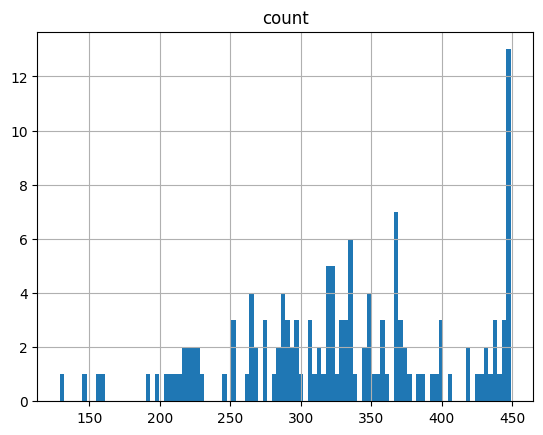

In [36]:
# 500 cells
cols = (df_cite_target > 0).sum(axis=0)
row = list(cols.index)
print(row)
cols = pd.DataFrame(cols[:],index=cols.index, columns=['count'])
# print(cols)
cols.hist(bins=100)

<AxesSubplot: >

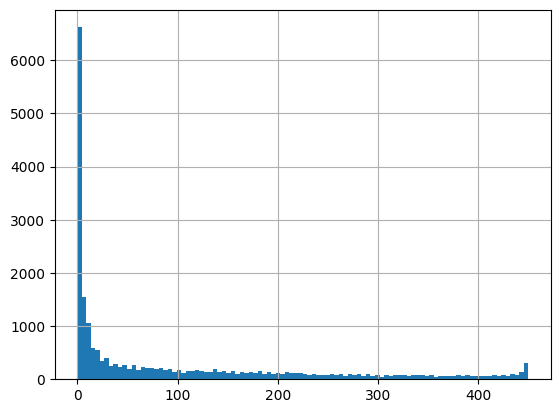

In [38]:
# sum of expression level per gene
cols = (df_cite_input > 0).sum(axis=0)
cols.hist(bins=100)


In [39]:
proteins = np.array([t.startswith('CD') for t in str_protein_id])
print("CD proteins: ", proteins.sum(), "non-CD proteins: ", (~proteins).sum())
print(df_cite_target.columns[~proteins])
w = [not((t[2:]).isnumeric()) for t in df_cite_target.columns[proteins] ]
print(df_cite_target.columns[proteins][w])

CD proteins:  119 non-CD proteins:  21
Index(['HLA-A-B-C', 'TIGIT', 'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b',
       'Rat-IgG2b', 'Podoplanin', 'IgM', 'KLRG1', 'HLA-DR', 'CX3CR1',
       'integrinB7', 'TCR', 'Rat-IgG1', 'Rat-IgG2a', 'FceRIa', 'IgD',
       'TCRVa7.2', 'TCRVd2', 'LOX-1', 'HLA-E'],
      dtype='object')
Index(['CD11c', 'CD45RA', 'CD49f', 'CD45RO', 'CD62L', 'CD107a', 'CD1c',
       'CD11b', 'CD1d', 'CD11a', 'CD79b', 'CD42b', 'CD62P', 'CD49b', 'CD172a',
       'CD49a', 'CD49d', 'CD158b', 'CD158e1', 'CD85j'],
      dtype='object')


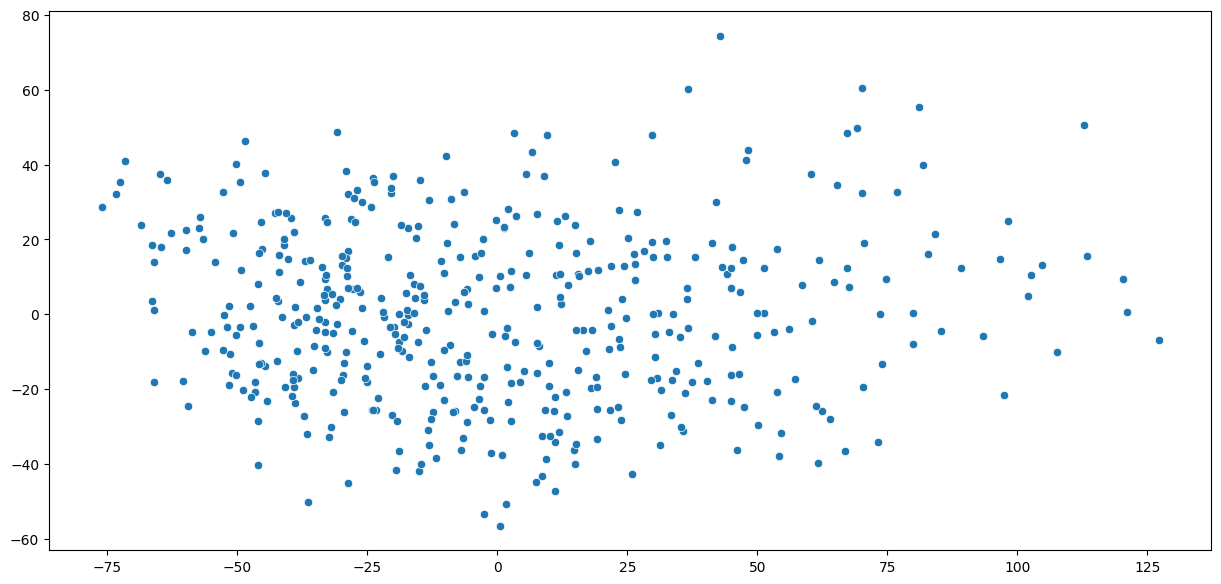

Text(0.5, 1.0, 'explained variance')

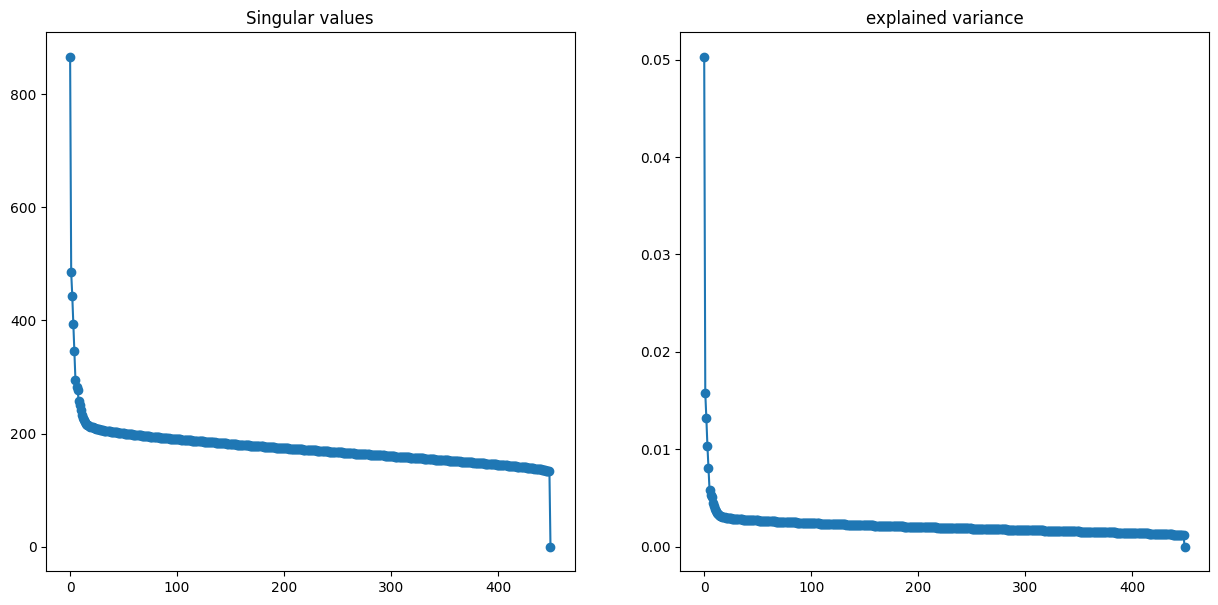

In [88]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
r = pca.fit_transform(df_cite_input)

fig = plt.figure(figsize = (15,7) )
c = 0
sns.scatterplot(x=r[:,0], y=r[:,1])# , hue = df[f]  )
plt.show()

fig = plt.figure(figsize = (15,7) )
fig.add_subplot(1, 2, 1) 
plt.plot(pca.singular_values_,'o-')
plt.title('Singular values')
fig.add_subplot(1, 2, 2) 
plt.plot(pca.explained_variance_ratio_,'o-')
plt.title('explained variance')

In [89]:
len(pca.feature_names_in_) # contains genes
r.shape # 50, 22050

(450, 450)

In [91]:
lim = 1
ACC_VAR = 0
for i, var in enumerate(pca.explained_variance_ratio_):
    ACC_VAR+=var
    # print(var)
    if ACC_VAR > lim: 
        print(f"{i+1} components explained {lim} of total var")
        break

449 components explained 1 of total var


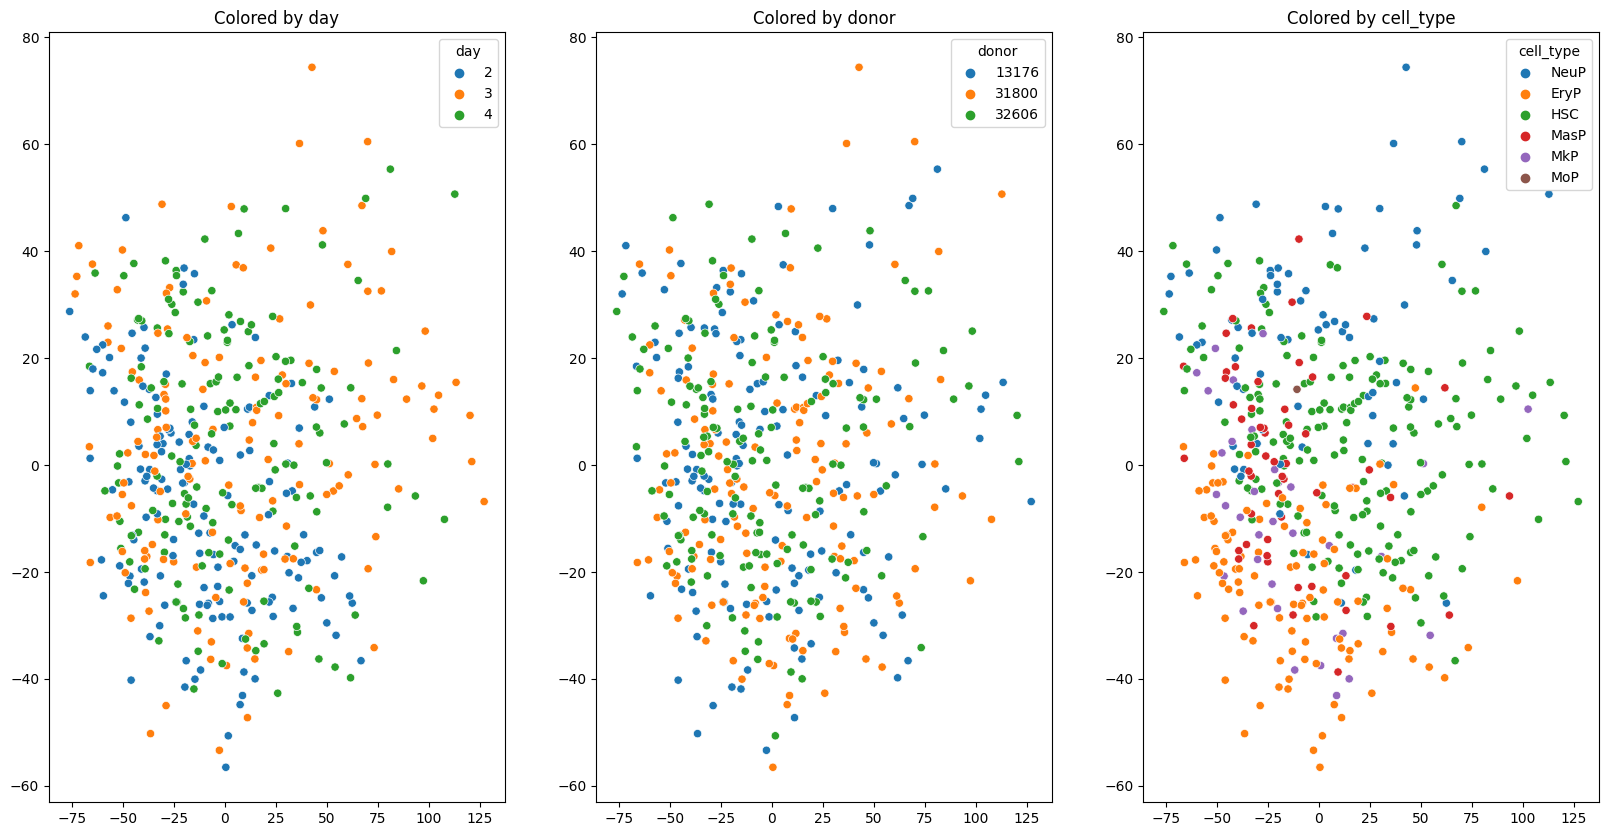

In [42]:
fig = plt.figure(figsize = (20,10) )
c = 0
for f in ['day', 'donor', 'cell_type']:# , 'technology']:
    c+=1; fig.add_subplot(1, 3 , c) 
    sns.scatterplot(x=r[:,0], y=r[:,1] , hue = df_meta_citeseq_subset[f], palette = "tab10"  )
    plt.title('Colored by '+f)
plt.show()


In [43]:
fig = plt.figure(figsize= (20,6))
dpca = {}
for i in range(5):
    v = pca.components_[i,:].ravel()
    t = np.percentile(np.abs(v),90)
    IX = np.where( np.abs(v) > t)[0]
    print(len(IX))
    l = np.array(str_gene_id)[IX]
    print(l[1:10],'and more ... Top columns contributing to  PCA'+str(i) )
    dpca[i] = l
    if i == 0:
        s = set(dpca[0])
    else:
        s = s & set(dpca[i])
        #print(s, 'Intersection',i)        
plt.show()
    
print()
s = set(dpca[0])
for i in dpca:
    s = s & set(dpca[i])
    print(len(s), 'Intersection',i)

2205
['ENSG00000090861_AARS' 'ENSG00000149313_AASDHPPT' 'ENSG00000275700_AATF'
 'ENSG00000125257_ABCC4' 'ENSG00000164163_ABCE1' 'ENSG00000204574_ABCF1'
 'ENSG00000033050_ABCF2' 'ENSG00000140526_ABHD2'
 'ENSG00000263272_AC004148.2'] and more ... Top columns contributing to  PCA0
2205
['ENSG00000115977_AAK1' 'ENSG00000107331_ABCA2' 'ENSG00000154265_ABCA5'
 'ENSG00000125257_ABCC4' 'ENSG00000164163_ABCE1' 'ENSG00000204574_ABCF1'
 'ENSG00000106077_ABHD11' 'ENSG00000136754_ABI1' 'ENSG00000143322_ABL2'] and more ... Top columns contributing to  PCA1
2205
['ENSG00000107331_ABCA2' 'ENSG00000103222_ABCC1' 'ENSG00000125257_ABCC4'
 'ENSG00000114770_ABCC5' 'ENSG00000033050_ABCF2' 'ENSG00000140526_ABHD2'
 'ENSG00000136754_ABI1' 'ENSG00000099204_ABLIM1' 'ENSG00000175164_ABO'] and more ... Top columns contributing to  PCA2
2205
['ENSG00000087884_AAMDC' 'ENSG00000154265_ABCA5' 'ENSG00000103222_ABCC1'
 'ENSG00000125257_ABCC4' 'ENSG00000138443_ABI2' 'ENSG00000099204_ABLIM1'
 'ENSG00000175164_ABO' 'ENSG00

<Figure size 2000x600 with 0 Axes>


2205 Intersection 0
666 Intersection 1
292 Intersection 2
100 Intersection 3
33 Intersection 4


C:\Users\xiaox\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<AxesSubplot: >

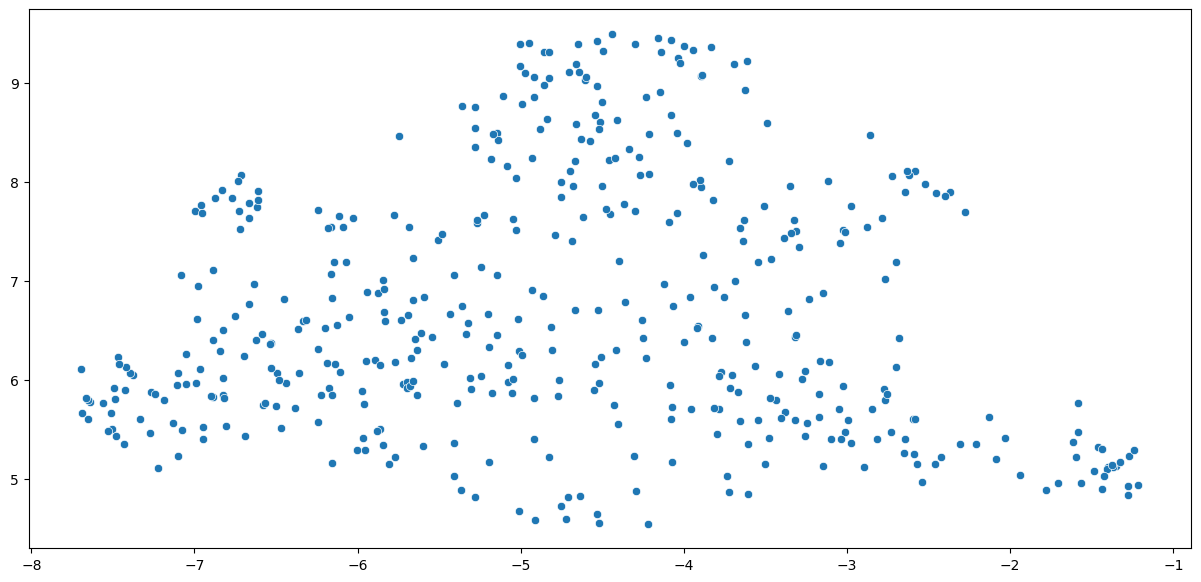

In [44]:
import umap

r = umap.UMAP().fit_transform(df_cite_input) # def neighbours = 15; components = 2

fig = plt.figure(figsize = (15,7) )
sns.scatterplot(x=r[:,0], y=r[:,1])#  , hue = df[f]  )
# plt.show()

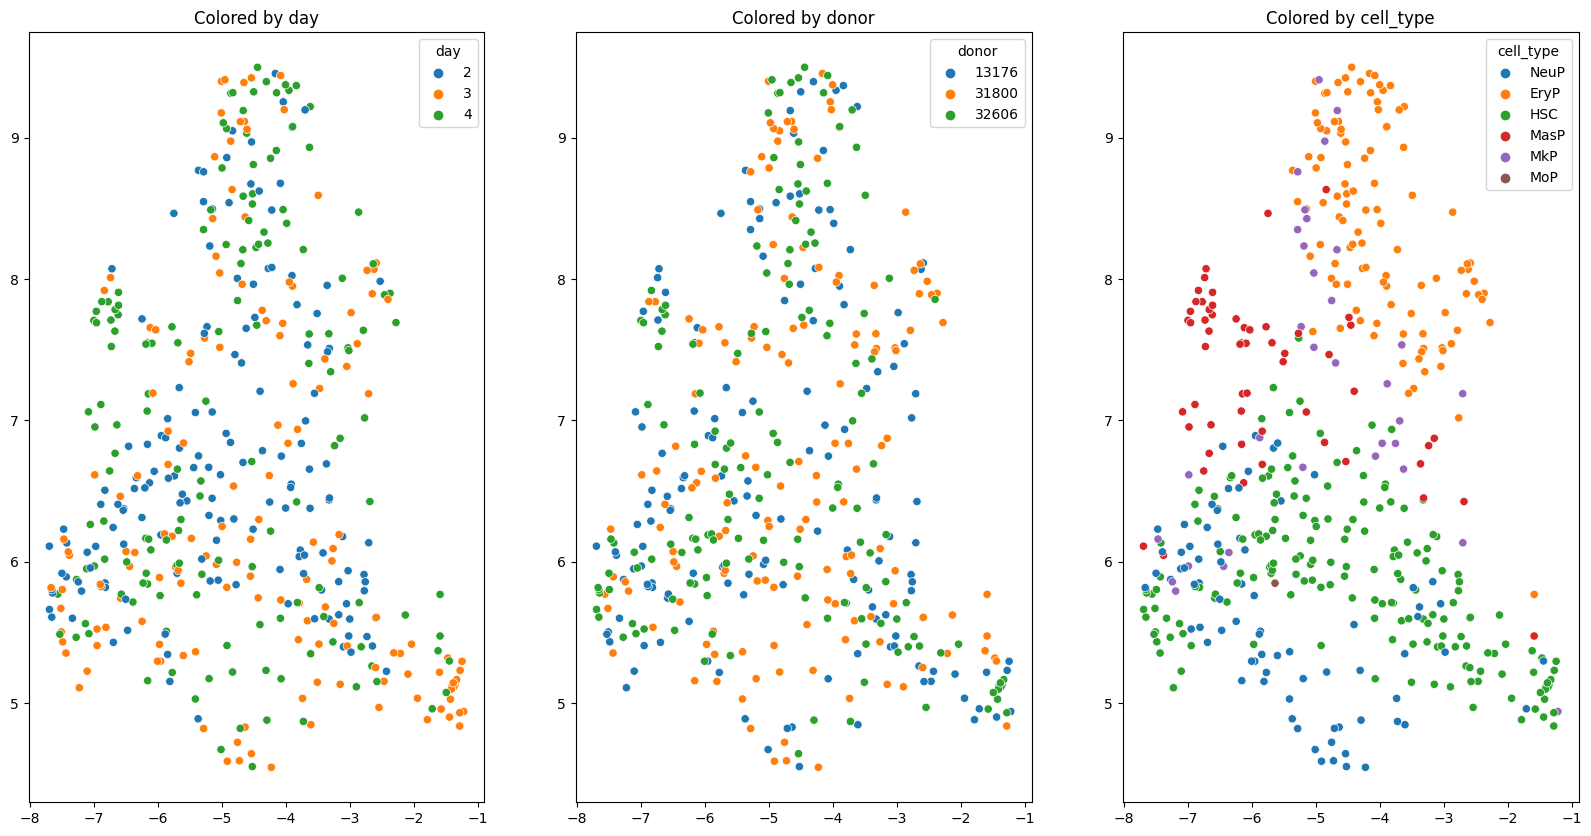

In [45]:
fig = plt.figure(figsize = (20,10) )
c = 0
for f in ['day', 'donor', 'cell_type']:
    c+=1; fig.add_subplot(1, 3 , c) 
    sns.scatterplot(x=r[:,0], y=r[:,1] , hue = df_meta_citeseq_subset[f], palette = 'tab10' )
    plt.title('Colored by '+f)
plt.show()


In [46]:
r.shape # 450,2 : representing samples using 2 values

(450, 2)

## truncated SVD + PCA

from dengkw, Models using the Truncated SVD to reduce the dimension with PCA - was ran with KRR - kernel ridge

In [58]:
# doing pca on input data
from sklearn.decomposition import TruncatedSVD

svd1 = TruncatedSVD()
pca1 = svd1.fit_transform(df_cite_input)

print(pca1.shape)
pca1

(450, 2)


array([[ 2.93402244e+02, -2.06150046e+01],
       [ 2.87708142e+02, -2.24561405e+01],
       [ 2.51428142e+02,  3.35059548e+01],
       [ 2.36953194e+02,  3.65705366e+01],
       [ 2.72668221e+02, -8.48509972e+00],
       [ 2.44651012e+02,  3.65482895e+01],
       [ 2.78450620e+02,  1.58375945e-01],
       [ 2.92396617e+02, -3.22511866e+01],
       [ 2.93362554e+02, -3.45129983e+01],
       [ 3.05655518e+02, -4.73322624e+01],
       [ 2.23347779e+02,  4.32469969e+01],
       [ 2.13249119e+02,  5.31451371e+01],
       [ 2.92879852e+02, -1.28137578e+01],
       [ 2.95985870e+02, -1.29714235e+01],
       [ 2.54639012e+02,  1.48318754e+01],
       [ 2.79254340e+02, -5.23306065e+00],
       [ 2.75381114e+02,  4.65317069e-02],
       [ 2.93197797e+02, -1.98913303e+01],
       [ 2.48672175e+02,  4.13063038e+01],
       [ 2.65943620e+02,  1.37473748e+01],
       [ 2.87485233e+02, -1.33182590e+01],
       [ 2.92414743e+02, -2.05030774e+01],
       [ 2.76046491e+02, -4.26443561e+00],
       [ 2.

Text(0.5, 1.0, 'explained variance')

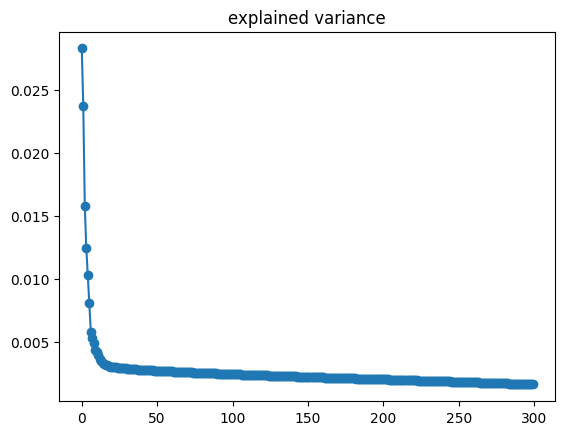

In [54]:
plt.plot(svd1.explained_variance_ratio_,'o-')
plt.title('explained variance')

In [69]:

ACC_VAR = 0
for i, var in enumerate(svd1.explained_variance_ratio_):
    ACC_VAR+=var
    # print(var)
    if ACC_VAR > .04: 
        print(f"{i+1} components explained 0.9 of total var")
        break

2 components explained 0.9 of total var


In [ ]:
# nromalisation, not really -> standardisation
train_sd = np.std(pca1, axis=1).reshape(-1,1)
train_sd[train_sd == 0] = 1
train_norm = (pca1 - np.mean(pca1, axis=1).reshape(-1, 1)) / train_sd

print(train_norm.shape)
train_norm

[[18.61214 ]
 [18.457918]
 [16.82743 ]
 [16.856127]
 [18.185135]
 [16.928684]
 [17.892065]
 [18.480778]
 [18.696262]
 [19.248589]]
(450, 300)


array([[ 1.5748729e+01, -1.1229136e+00,  1.8470219e-01, ...,
         7.9392636e-01,  5.4997306e-02, -6.5377992e-01],
       [ 1.5532993e+01, -1.2708297e+00, -1.8146900e+00, ...,
        -5.9155029e-01, -1.1649454e-01,  8.4253293e-01],
       [ 1.4931954e+01,  1.9814874e+00, -8.8793087e-01, ...,
         4.1511816e-01,  2.2961244e-01,  6.3194344e-03],
       ...,
       [ 1.5272189e+01, -1.2101411e+00,  6.7530268e-01, ...,
         1.1829206e+00,  5.5012065e-01, -1.4981967e-01],
       [ 1.3897835e+01,  1.4954754e+00,  1.0802013e+00, ...,
        -1.2337588e-01, -5.6189388e-01, -3.3728859e-01],
       [ 1.5034127e+01, -7.1243203e-01, -2.0605619e+00, ...,
        -9.7834051e-01,  1.9646924e-02,  2.2380063e-01]], dtype=float32)

In [ ]:
train_norm[1,:].shape

(300,)

In [ ]:
row = []
for i in range(300):
    x = "PCA"+ str(i)
    row.append(x)

results = pd.DataFrame(train_norm, columns = [row], index = df_meta_citeseq_subset['cell_id'])
results.to_csv("reduced/train_cite_reduced.csv", index=False)

In [ ]:
 sc.pp.calculate_qc_metrics(adata_GEX, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)